In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
import wandb
wandb.login()

wandb: Currently logged in as: sahaana (use `wandb login --relogin` to force relogin)


True

# Imports 

In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DistilBertModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [7]:
import sys
#sys.path.append('/lfs/1/sahaana/enrichment/enrich/utils')
sys.path.append('/lfs/1/sahaana/enrichment/ember/utils')
 
    
from embedding_datasets import SQuADDataset, EmberEvalDataset
from embedding_models import TripletSingleBERTModel
from embedding_utils import param_header, tokenize_batch  
from embedding_runner import train_model, eval_model
#from model_utils import MatchedDatasetTriplets, param_header_bert, tokenize_batch   
#from models import BatchedTripletSingleTowerModel, BatchedTripletSingleBERTModel
#from model_runner import train_model, eval_model
from knn_utils import FaissKNeighbors, knn_SQuAD_recall #, knn_matching_accuracy, find_perfect_recall

ImportError: cannot import name 'knn_SQuAD_recall' from 'knn_utils' (/lfs/1/sahaana/enrichment/ember/utils/knn_utils.py)

In [ ]:
%load_ext autoreload
%autoreload 2

# Load Processed (cleaned, aligned) Datasets

In [8]:
left = '/lfs/1/sahaana/enrichment/data/SQuAD/train_tableA_processed.pkl'
right = '/lfs/1/sahaana/enrichment/data/SQuAD/train_tableB_para_processed.pkl'

left = pd.read_pickle(left)
right = pd.read_pickle(right)

In [9]:
left

,question,merged_all
QID,,
0,When did Beyonce start becoming popular?,[SEP] question When did Beyonce start becomi...
1,What areas did Beyonce compete in when she was...,[SEP] question What areas did Beyonce compet...
2,When did Beyonce leave Destiny's Child and bec...,[SEP] question When did Beyonce leave Destin...
3,In what city and state did Beyonce grow up?,[SEP] question In what city and state did Be...
4,In which decade did Beyonce become famous?,[SEP] question In which decade did Beyonce b...
...,...,...
86816,In what US state did Kathmandu first establish...,[SEP] question In what US state did Kathmand...
86817,What was Yangon previously known as?,[SEP] question What was Yangon previously kn...
86818,With what Belorussian city does Kathmandu have...,[SEP] question With what Belorussian city do...


In [10]:
right

,paragraph,merged_all
PID,,
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,[SEP] paragraph Beyoncé Giselle Knowles-Cart...
1,Following the disbandment of Destiny's Child i...,[SEP] paragraph Following the disbandment of...
2,"A self-described ""modern-day feminist"", Beyonc...","[SEP] paragraph A self-described ""modern-day..."
3,"Beyoncé Giselle Knowles was born in Houston, T...",[SEP] paragraph Beyoncé Giselle Knowles was ...
4,Beyoncé attended St. Mary's Elementary School ...,[SEP] paragraph Beyoncé attended St. Mary's ...
...,...,...
18975,"Institute of Medicine, the central college of ...","[SEP] paragraph Institute of Medicine, the c..."
18976,Football and Cricket are the most popular spor...,[SEP] paragraph Football and Cricket are the...
18977,The total length of roads in Nepal is recorded...,[SEP] paragraph The total length of roads in...


(array([8.6767e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

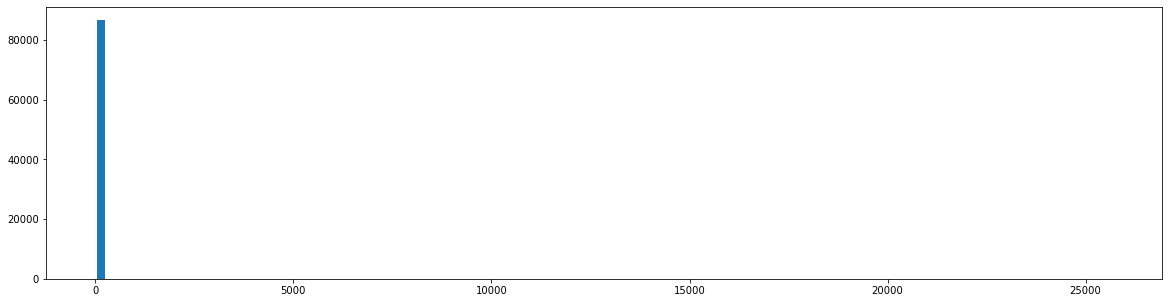

In [11]:
plt.figure(figsize=(20,5))
plt.hist(left['merged_all'].apply(lambda x: len(x)), bins=100, rwidth = .85)

(array([2.100e+02, 2.220e+02, 2.390e+02, 2.870e+02, 3.100e+02, 3.130e+02,
        2.990e+02, 2.830e+02, 2.870e+02, 4.960e+02, 1.602e+03, 1.402e+03,
        1.342e+03, 1.197e+03, 1.168e+03, 1.051e+03, 9.260e+02, 8.270e+02,
        7.340e+02, 6.350e+02, 6.460e+02, 5.220e+02, 4.570e+02, 4.150e+02,
        3.390e+02, 3.440e+02, 2.710e+02, 2.730e+02, 2.030e+02, 1.960e+02,
        1.970e+02, 1.550e+02, 1.320e+02, 1.180e+02, 9.000e+01, 9.500e+01,
        7.400e+01, 6.000e+01, 5.600e+01, 5.500e+01, 4.300e+01, 4.100e+01,
        3.300e+01, 2.600e+01, 2.700e+01, 2.200e+01, 1.400e+01, 1.100e+01,
        2.700e+01, 1.200e+01, 8.000e+00, 9.000e+00, 8.000e+00, 8.000e+00,
        1.000e+01, 9.000e+00, 4.000e+00, 5.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

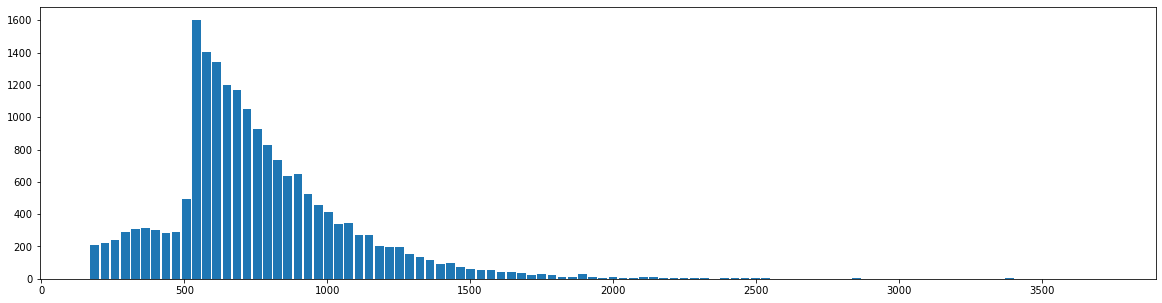

In [18]:
plt.figure(figsize=(20,5))
plt.hist(right['merged_all'].apply(lambda x: len(x)), bins=100, rwidth = .85)

# Prepping Data Indices

In [9]:
train_df = '/lfs/1/sahaana/enrichment/data/SQuAD/train_para_triplets.pkl'
train_df = pd.read_pickle(train_df)

val_df = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_para_labels.pkl'
val_df = pd.read_pickle(val_df)

## Model H Params

In [10]:
epochs = 1
batch_size = 8
final_size = 200
lr = .00001
tl_margin = 1.0
tl_p = 2
pool_type = "CLS"
column = "merged_all"
shuffle = True
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_max_length = 512
compute_val = False
train_size = int(len(train_df)/8)
    

bert_path='/lfs/1/sahaana/enrichment/ember/pretraining/models/SQuAD_para-uncased-masked-ALL-BM25'
bert_model = DistilBertModel.from_pretrained(bert_path, return_dict=True)

model_name = f'SQuAD_para-uncased-masked-ALL-BM25-dummy'

## DataLoaders

In [35]:
train_data = DataLoader(SQuADDataset(left, right, len(train_df), column, train_df), 
                        batch_size=batch_size,
                        shuffle = shuffle
                        )

val_data = None 
"""DataLoader(SQuADDataset(left, right, len(val_df), column, val_df), 
                       batch_size=batch_size,
                       shuffle = False
                      )"""

'DataLoader(SQuADDataset(left, right, len(val_df), column, val_df), \n                       batch_size=batch_size,\n                       shuffle = False\n                      )'

## Init and Run Model

In [36]:
triplet_loss = nn.TripletMarginLoss(margin=tl_margin, p=tl_p)
losses = []
val_losses = []
model = TripletSingleBERTModel(final_size, pool_type, bert_path)
optimizer = optim.AdamW(model.parameters(), lr=lr)#optim.SGD(model.parameters(), lr=lr)

In [37]:
save_dir = param_header(batch_size, final_size, lr, pool_type, epochs, train_size)
save_dir = f'models/{model_name}/{save_dir}/'

In [38]:
wandb.init(project=model_name)

Epoch,0
_step,32532
_runtime,6454
_timestamp,1613463626
train batch loss,0.0


Epoch,▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train batch loss,▄▂▃▁▃▄█▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▃▁▁▁▂▁▁▂▁


wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
train_model(model, 
            tokenizer, 
            tokenize_batch, 
            train_data, 
            val_data, 
            triplet_loss, 
            optimizer, 
            epochs, 
            losses, 
            val_losses, 
            save_dir, 
            compute_val, 
            tokenizer_max_length = tokenizer_max_length)

# k-NN Model Performance

In [27]:
left_eval = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_tableA_processed.pkl'
right_eval = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_tableB_para_processed.pkl'
test = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_para_labels.pkl'

left_eval = pd.read_pickle(left_eval)
right_eval = pd.read_pickle(right_eval)
test_df = pd.read_pickle(test)

In [28]:
#PATH = "models/single-tower-BERT-triplet-model/batch_size-8-final_size-50-opt_lr-0.0001-tloss_margin-1.0-tloss_p-2-pooling-CLS-shuffle-True00-35-05-01-21"
#model.load_state_dict(torch.load(PATH))

left_eval_data = DataLoader(EmberEvalDataset(left_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )
right_eval_data = DataLoader(EmberEvalDataset(right_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )

In [29]:
left_index, left_embeddings = eval_model(model, tokenizer, left_eval_data, tokenizer_max_length=512)
right_index, right_embeddings = eval_model(model, tokenizer, right_eval_data, tokenizer_max_length=512)

In [30]:
knn = FaissKNeighbors(k=30)
knn.fit(right_embeddings)
neib = knn.kneighbors(left_embeddings)

In [33]:
for k in range(1,31):
    avg, count, MRR, results, MRR_results = knn_SQuAD_recall(neib[0], neib[1], test_df, left_index, right_index, 'PID', k=k)
    print(f"k: {k} \t avg: {avg} \t count: {count} \t MRR: {MRR}")

k: 1 	 avg: 0.5249746878164023 	 count: 3111 	 MRR: 0.5249746878164023
k: 2 	 avg: 0.6552480593992575 	 count: 3883 	 MRR: 0.59011137360783
k: 3 	 avg: 0.7232534593317583 	 count: 4286 	 MRR: 0.6127798402519968
k: 4 	 avg: 0.7671279109011138 	 count: 4546 	 MRR: 0.6237484531443357
k: 5 	 avg: 0.795308808639892 	 count: 4713 	 MRR: 0.6293846326920913
k: 6 	 avg: 0.8172460344245697 	 count: 4843 	 MRR: 0.6330408369895376
k: 7 	 avg: 0.8344583192710091 	 count: 4945 	 MRR: 0.6354997348247432
k: 8 	 avg: 0.8479581505231185 	 count: 5025 	 MRR: 0.637187213731257
k: 9 	 avg: 0.8587580155248059 	 count: 5089 	 MRR: 0.6383871987314443
k: 10 	 avg: 0.868882888963888 	 count: 5149 	 MRR: 0.6393996860753526
k: 11 	 avg: 0.8783327708403645 	 count: 5205 	 MRR: 0.6402587662459414
k: 12 	 avg: 0.8862639217009788 	 count: 5252 	 MRR: 0.6409196954843259
k: 13 	 avg: 0.8928450894363821 	 count: 5291 	 MRR: 0.64142593915628
k: 14 	 avg: 0.899257509281134 	 count: 5329 	 MRR: 0.6418839691451907
k: 15 	 a

In [14]:
import time

In [16]:
start = time.time()
left_eval = '/lfs/1/sahaana/enrichment/data/MSMARCO/tableA_processed.pkl'
#right_eval = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_tableB_para_processed.pkl'
#test = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_para_labels.pkl'

left_eval = pd.read_pickle(left_eval)
#right_eval = pd.read_pickle(right_eval)
#test_df = pd.read_pickle(test)

#PATH = "models/single-tower-BERT-triplet-model/batch_size-8-final_size-50-opt_lr-0.0001-tloss_margin-1.0-tloss_p-2-pooling-CLS-shuffle-True00-35-05-01-21"
#model.load_state_dict(torch.load(PATH))
model = TripletSingleBERTModel(final_size, pool_type, bert_path)

print (time.time() - start)
left_eval_data = DataLoader(EmberEvalDataset(left_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )
"""right_eval_data = DataLoader(EmberEvalDataset(right_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )"""
print (time.time() - start)
left_index, left_embeddings = eval_model(model, tokenizer, left_eval_data, tokenizer_max_length=512)
#right_index, right_embeddings = eval_model(model, tokenizer, right_eval_data, tokenizer_max_length=512)
print (time.time() - start)
#knn = FaissKNeighbors(k=30)
#knn.fit(right_embeddings)
#neib = knn.kneighbors(left_embeddings)

#for k in range(1,31):
#    avg, count, MRR, results, MRR_results = knn_SQuAD_recall(neib[0], neib[1], test_df, left_index, right_index, 'PID', k=k)
#    print(f"k: {k} \t avg: {avg} \t count: {count} \t MRR: {MRR}")

1.187075138092041
1.2611236572265625
934.9737114906311
